<a href="https://colab.research.google.com/github/NahuelCostaCortez/AI_notebooks/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial on [Pix2Pix](https://arxiv.org/pdf/1611.07004.pdf) architecture**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

**DATA PREPROCESSING**

In [ ]:
# Root path
PATH = "/content/drive/My Drive/flowersData"

# Input data path
INPATH = PATH + "/inputFlowers"

# Output data path
OUTPATH = PATH + "/targetFlowers"

# Route of the checkpoints
CKPATH = PATH + '/checkpoints'

# Console commands
# List the elements of the indicated folder (the -1 is to show them all in 1 single column).
imgurls = !ls -1 "{INPATH}" 

In [ ]:
# A shuffle must be performed to reorder the data because they are logically sorted.

# 500 images
n = 500
# 80% for training
train_n = round(n * 0.8)

# Copy of the list of images urls
randurls = np.copy(imgurls)

# Seed so that the reordering is the same each time it is executed
np.random.seed(23)
# Shuffle organizing the filenames randomly
np.random.shuffle(randurls)

# train/test split
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print("all-train-test")
print(len(imgurls), len(tr_urls), len(ts_urls))

all-train-test
7725 400 100


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT= 256

# Image rescaling
def resize(inimg, tgimg, height, width):
  
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width]) 
  
  return inimg, tgimg

# Normalize the image to the range [-1, 1]
def normalize(inimg, tgimg):
  
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg, tgimg

# Data augmentation : Random Crop + Flip
# Generate more images from the existint transformations
# In this case the image size is increased (zoom), namely 286 * 286,
# thus achieving a random displacement, then flip the image (flip). 
def random_jitter(inimg, tgimg):
  
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  # The transformations have to be the same in both images, that's why it is applied to stacked_image
  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  # Random cropping to the two images at 286*286 with 3 color channels we have
  cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  # Take the first and the second and save them in inimg and tgimg
  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  # The parentheses generate a random number and if it is greater than 0.5 the image is flipped,
  # otherwise it is left as is
  # With the "eager mode" of tensorflow 2.0, which is activated by default, tf.random.uniform(())
  # generates a tensor with value
  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
    
  return inimg, tgimg

def load_image(filename, augment=True):
  # The image is loaded as float [...] keeps all dimensions [,:3] limits
  # the last dimension to only 3 components because it could come with more than RGB
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  reimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[..., :3]
  
  inimg, reimg = resize(inimg, reimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, reimg = random_jitter(inimg, reimg)
    
  inimg, reimg = normalize(inimg, reimg)
  
  return inimg, reimg

def load_train_image(filename):
  return load_image(filename, True)

# Data augmentation is not applied in test
def load_test_image(filename):
  return load_image(filename, False)

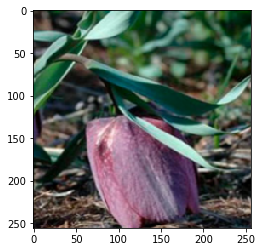

In [ ]:
# +1 / 2 because imshow goes from 0 to 1, not from -1 to 1.
plt.imshow((load_train_image(randurls[0])[1] + 1) / 2)

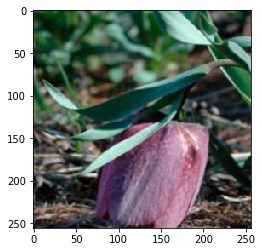

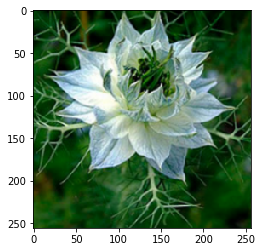

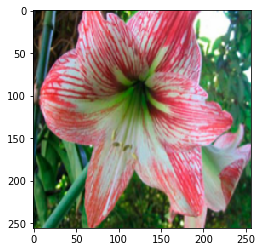

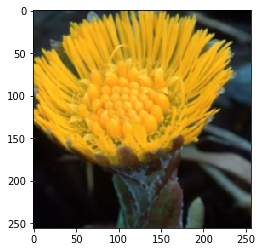

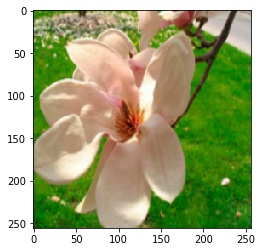

In [ ]:
# dataset from a list of specified elements
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
# load images. map applies the specified function to the list of filenames of train_dataset
# num_parallel_calls: Number of parallel processing (decide tensorflow)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Create batches (in this case of 1)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

# Display batch data -> 5 batches of size 1 (train_dataset.take(5))
for inimg, tgimg in train_dataset.take(5):
  plt.imshow((tgimg[0] + 1) / 2)
  plt.show()

**PIX2PIX ARCHITECTURE DESIGN**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import *

![](https://drive.google.com/uc?id=1vczDLTzEfujeu6-v-1PA9rT9hts7k0XP)

**Encoder**

Convolutional network that at the end returns a value (e.g. label of what is in the image).

In [ ]:
# Function to generate the blocks that will be needed to design the encoder.
# Image compression in the encoder (convolutional network)
def downsample(filters, apply_batchnorm=True):
  # Layers according to the Pix2Pix paper: Convolution - BatchNormalization - Relu
  result = Sequential()
  
  # Weights are initialized from a Gaussian distribution of mean 0 and variance 0.02.
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Convolutional layer
  # convolutions are of spatial filters of size 4x4
  # stride is how many pixels the filter will move over the image.
  # padding is specified to be equal to preserve the size of the feature maps as they pass through the layers.
  # batchNormalization in addition to doing the normalization adds a number of parameters  
  # equivalent to having a bias parameter in the previous layer (Conv2D), it uses
  # use_bias to add the bias parameter whenever it is not being applied.
  # batch normalization in the next layer
  result.add(Conv2D(filters, 
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    result.add(BatchNormalization())
  
  result.add(LeakyReLU())
  
  return result

downsample(64)

**Decoder**

Deconvolutional network, from a numerical value predicts the output (in this case an image of a flower). 
Usually the input numeric value is a vector of random numbers, but here the output is conditioned from another vector that will indicate the type of output you want it to make (in this case, a picture of a flower). 
from another vector that will indicate the type of output you want it to make (in this case the flowers of the dataset).
That is, you condition the output based on the input (this is basically what BigGAN does).
So what is done here is to predict the pixels of an image from the pixels of another image (Pix2Pix), 
the image is passed through the encoder, mixed with the vector of random numbers and passed through the decoder to generate the new image.

In [ ]:
# Function to generate the blocks that will be needed to design the decoder.
# Decompression of the image in the decoder (convolutional network)
def upsample(filters, apply_dropout=False):
  # Layers according to the Pix2Pix paper: Convolution - BatchNormalization - Relu
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Inverse convolutional
  result.add(Conv2DTranspose(filters, 
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=False))
  
  result.add(BatchNormalization())
  
  if apply_dropout:
    result.add(Dropout(0.5))
  
  result.add(ReLU())
  
  return result

upsample(64)

The problem here is that when the information passes through the encoder, before passing through the encoder, there is a bottleneck, because the information is highly compressed and it is possible that this information is not enough to generate the realistic outputs that are wanted, the solution to this problem is in the skip-connections. It is delegated to the network if it wants to use the fully compressed information, or if it wants to take information prior to the total compression (bottleneck).

**Generator - U-NET architecture**

U-NET architecture based on encoder-decoder with skip connections to capture low-level information.

W0828 10:11:23.883341 140321767688064 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


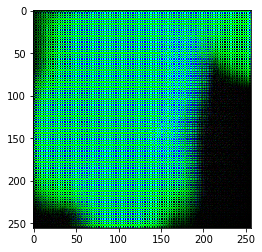

In [ ]:
def Generator():
  
  # width x height x color channels
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  # Set of blocks of the network 
  # In the encoder the dimensions are reduced by half.
  # and the number of channels corresponds to the number of filters we have.
  
  # Encoder
  down_stack = [
      downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
      downsample(128),                       # (bs, 64, 64, 128)
      downsample(256),                       # (bs, 32, 32, 256)
      downsample(512),                       # (bs, 16, 16, 512)
      downsample(512),                       # (bs, 8, 8, 512)
      downsample(512),                       # (bs, 4, 4, 512)
      downsample(512),                       # (bs, 2, 2, 512)
      downsample(512),                       # (bs, 1, 1, 512)
  ]
  
  # Decoder
  up_stack = [
      upsample(512, apply_dropout=True),     # (bs, 2, 2, 1024)
      upsample(512, apply_dropout=True),     # (bs, 4, 4, 1024)
      upsample(512, apply_dropout=True),     # (bs, 8, 8, 1024)
      upsample(512),                         # (bs, 16, 16, 1024)
      upsample(256),                         # (bs, 32, 32, 512)
      upsample(128),                         # (bs, 64, 64, 256)
      upsample(64),                          # (bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Last layer: generates the image we are looking for.
  # It is also an upsampling because we come from a 128x128 image,
  # and in this case the number of filters should be 3 -> 3 color channels. 
  # The activation function is also specified, here the images come from
  # the range from -1 to 1, so a tangent is used.
  last = Conv2DTranspose(filters=3,
                        kernel_size=4,
                        strides=2,
                        padding="same",
                        kernel_initializer=initializer,
                        activation="tanh")
  
  # Connecting each of the encoder layers
  x = inputs 
  
  # U-NET architecture skips connections
  s=[]
  
  concat = Concatenate()
  
  # The output of each layer is stored in x.
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  # The corresponding elements are stored, which are the same in the decoder,
  # but in reverse, the last element is not needed (bottleneck).
  s = reversed(s[:-1])
      
  # Connect each of the decoder layers.
  # upsampling, then concatenate the result with the first skip connection,
  # then that's going to be the input for the next iteration...
  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk])
    
  last = last(x)
  
  return Model(inputs=inputs, outputs=last)

generator = Generator()

# Example of generation with the generator
gen_output = generator(((inimg+1)*255), training=False)
plt.imshow(gen_output[0])

**Discriminator - PATCHGAN architecture**

Convolutional network (therefore only encoder) that instead of arriving at a value specifying whether the image is true or false, returns a grid where different portions (patches) of the original image are evaluated, specifying whether those portions are true or not.

![](https://drive.google.com/uc?id=1n4BDooHEFfa3Cn77ODcpC-_NFMyp4e89)

TensorShape([1, 16, 16, 1])

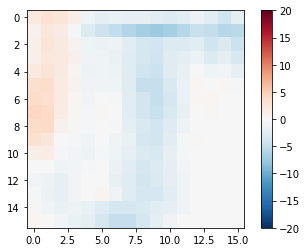

In [ ]:
# It is also a conditional discriminator, i.e. it has access to the input image (the scribble), which is passed to it as input.
# image (the scribble), which is passed to it as input. Explain if the output of the generator 
# corresponds to the real image.
def Discriminator():
  
  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gen_img")
  
  con = concatenate([ini, gen])
  
  # Parameters specified in the paper
  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  # Only a single information channel is needed, where it is defined for each # pixel whether the region looks real or not.
  # pixel whether the region looks real or not.
  last = tf.keras.layers.Conv2D(filters=1,
                               kernel_size=4,
                               strides=1,
                               kernel_initializer=initializer,
                               padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

# Example of discriminator output
disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape
# The areas of more intense colors identify those parts as unrealistic or false.

**Cost functions**

In [ ]:
# Calculate the cross entropy of each of the pixels of the images we are obtaining.
# from_logits so that the images that we obtain as input are normalized by passing them through 
# a sigmoid function bounding them between the domain 0 and 1
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # BinaryCrossentropy between the discriminator output,
  # which should be all 1s because it is evaluating the real image and all 1s
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  # BinaryCrossentropy between the discriminator output,
  # which should be all 0s because it is evaluating the image generated by the generator
  # and all 0s
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
# hyperparameter to regulate whether we want to add a higher degree of error of one component or the other
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  # The error of the patch array generated by the discriminator must be minimized,
  # then you tell it the BinaryCrossentropy between the patch array and what the generator would want it to be, which would be all 1s.
  # the generator would want it to be, which would be all 1s.
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error -> difference between generated and actual
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [ ]:
import os

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Save training run statuses (in case the system crashes, restore everything)
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generador_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Restoration
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [ ]:
# Generate and display images
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save:img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      
  plt.show()

In [ ]:
def train_step(input_image, target):
  
  # Object that allows us to access gradients and optimize weights.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    # The generator receives the flower doodle and generates something.
    output_image = generator(input_image, training=True)

    # Evaluation of the discriminator for the image generated by the discriminator 
    output_gen_discr = discriminator([output_image, input_image], training=True)

    #Evaluation of the discriminator for the real image
    output_target_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_target_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)

    # Optimization
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = gen_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_'+ str(epoch), display_imgs=True)
      imgi += 1
      
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
train(train_dataset, 100)